In [166]:
import jax
from jax.scipy.sparse.linalg import cg
import jax.numpy as jnp
from jax import random, grad, vmap, jit
from jax.numpy.linalg import lstsq
import matplotlib.pyplot as plt
import natgrad.mlp as mlp
from jax import flatten_util
import matplotlib
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

In [113]:
it = 150
data = jnp.load(f'/Users/mauriciodiaz.ortiz/Documents/Radboud_Phd/NaturalGradients/NaturalGradientTraining/data/poisson_1D/poisson_pinn_1d_{it}.npy', allow_pickle=True)
cg = data.item()['cg']
cg.keys()

ls = data.item()['ls']

In [116]:
seed   = 2
a     = 0.
b     = 1.
omega = 4.
activation = lambda x : jnp.tanh(x)
layer_sizes = [1, 16,  1]
params_0 = mlp.init_params(layer_sizes, random.PRNGKey(seed))
params_1 = params_0.copy()
model = mlp.mlp(activation)

def u_star(x):
    x = x[0]
    return jnp.sin(omega*jnp.pi*x)

@jit
def f(x):
    x = x[0]
    return jnp.pi**2 *omega**2* jnp.sin(omega*jnp.pi*x) 

def update_step(x, param, natgrad_flat):
    natgrad_ = flatten_util.ravel_pytree(natgrad_flat)[0]
    grad_ = flatten_util.ravel_pytree(grad(model, (0))(param, x))[0]
    return jnp.dot(grad_, natgrad_)

def wrap(func, *args):
    return jit(vmap(lambda x: func(x, *args), (0)))

In [117]:
domain = jnp.linspace(a, b, 100).reshape(-1, 1)
real = vmap(u_star, (0))(domain)

output_cg = vmap(lambda x: model(cg['params'], x), (0))(domain)
error_cg = wrap(lambda x, par: (model(par, x) - u_star(x)), cg['params'])(domain)
step_cg = (wrap(update_step, cg['params'], cg['natgrad']))(domain)

output_ls = vmap(lambda x: model(ls['params'], x), (0))(domain)
error_ls = wrap(lambda x, par: (model(par, x) - u_star(x)), ls['params'])(domain)
step_ls = (wrap(update_step, ls['params'], ls['natgrad']))(domain)

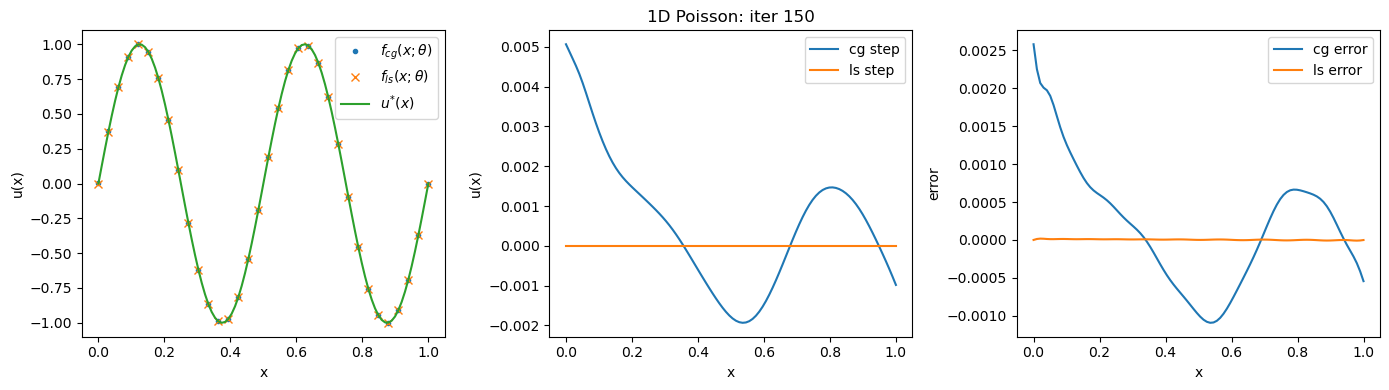

In [118]:

plt.figure(figsize=(14,4), dpi=100)

plt.subplot(1,3,1)
plt.plot(domain[::3], output_cg[::3], '.')
plt.plot(domain[::3], output_ls[::3], 'x')
plt.plot(domain, real)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend([r'$f_{cg}(x;\theta)$', r'$f_{ls}(x;\theta)$', r'$u^{*}(x)$'])

plt.subplot(1,3,2)
plt.plot(domain, step_cg)
plt.plot(domain, step_ls)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend(['cg step', 'ls step'])
plt.title(f'1D Poisson: iter {it}')

plt.subplot(1,3,3)
plt.plot(domain, error_cg)
plt.plot(domain, error_ls)
plt.xlabel('x')
plt.ylabel('error')
plt.legend(['cg error', 'ls error'])


plt.tight_layout()


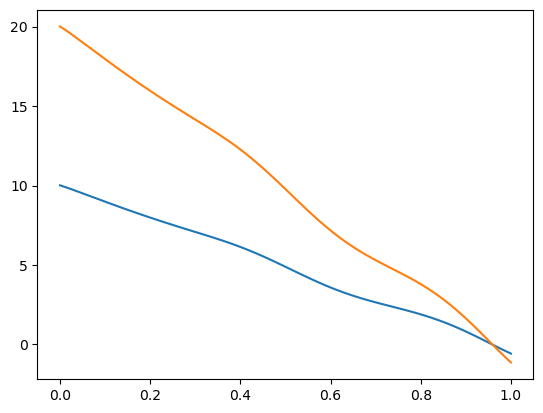

In [81]:


plt.plot(domain, error)
plt.plot(domain, step)

## Testing the LM implementation

In [144]:
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit
from matplotlib import pyplot as plt
import numpy as np

from jax.numpy.linalg import lstsq
from jax.scipy.sparse.linalg import cg

import natgrad.mlp as mlp
from natgrad.domains import Interval
from natgrad.domains import PointBoundary
from natgrad.integrators import DeterministicIntegrator
from natgrad.derivatives import laplace
from natgrad.inner import model_laplace, model_identity
from natgrad.gram import gram_factory, nat_grad_factory, nat_grad_factory_generic
from natgrad.utility import grid_line_search_factory
from natgrad.plotting import poission_1d_plot
from jaxopt import LevenbergMarquardt

jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)

# random seed and parameters
seed       = 2
a          = 0.
b          = 1.
omega      = 1.
eps        = 1e-4
iterations = 500
plot       = True
save       = False

interior = Interval(a, b)
boundary = PointBoundary(((a, b)))

# integrators
interior_integrator = DeterministicIntegrator(interior, 50)
boundary_integrator = DeterministicIntegrator(boundary, 50)
eval_integrator = DeterministicIntegrator(interior, 300)

activation = lambda x : jnp.tanh(x)
layer_sizes = [1, 16, 1]
params_0 = mlp.init_params(layer_sizes, random.PRNGKey(seed))

model = mlp.mlp(activation)
v_model = vmap(model, (None, 0))

@jit
def u_star(x):
    x = x[0]
    return jnp.sin(omega*jnp.pi*x)

# rhs
@jit
def f(x):
    x = x[0]
    return jnp.pi**2 *omega**2* jnp.sin(omega*jnp.pi*x) 

# trick to get the signature (params, v_x) -> v_residual
_residual = lambda params: laplace(lambda x: model(params, x))
residual = lambda params, x: (_residual(params)(x) + f(x))**2.
v_residual =  jit(vmap(residual, (None, 0)))


params_2 = params_0.copy() 
params_2, unflatten = jax.flatten_util.ravel_pytree(params_2)

res_bdry = lambda params, x: model(params, x)
v_res_bdry = jit(vmap(res_bdry, (None, 0)))

def residuals_lm(params):
    params = unflatten(params)
    boundary_res_pts = vmap(res_bdry, (None, 0))(params, boundary_integrator._x) / len(boundary_integrator._x)
    interior_res_pts = vmap(residual, (None, 0))(params, interior_integrator._x) / len(interior_integrator._x)
    return jnp.concatenate([boundary_res_pts, interior_res_pts])

@jit
def interior_loss(params):
    return interior_integrator(lambda x: v_residual(params, x))

@jit
def boundary_loss(params):
    boundary_integrand = lambda x: model(params, x)**2
    return boundary_integrator(vmap(boundary_integrand, (0)))

@jit
def loss(params):
    return interior_loss(params) + boundary_loss(params)[0]



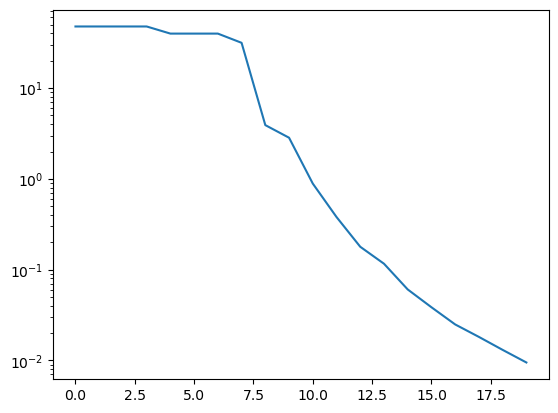

In [147]:
leven_marq = LevenbergMarquardt(residuals_lm, damping_parameter=eps, maxiter=1, tol=1e-10)

its = 20
losses = np.zeros(its)
for i in range(its):
    if i == 0:
        out = leven_marq.run(params_2)
    else:
        out = leven_marq.update(out.params, out.state)

    losses[i] = loss(unflatten(out.params))

plt.semilogy(losses)
plt.show()

In [141]:
losses

array([47.74033463, 47.74033463, 47.74033463, 47.74033463, 39.85047235,
       39.85047235, 39.85047235, 31.54164212,  3.90992023,  2.84004051])

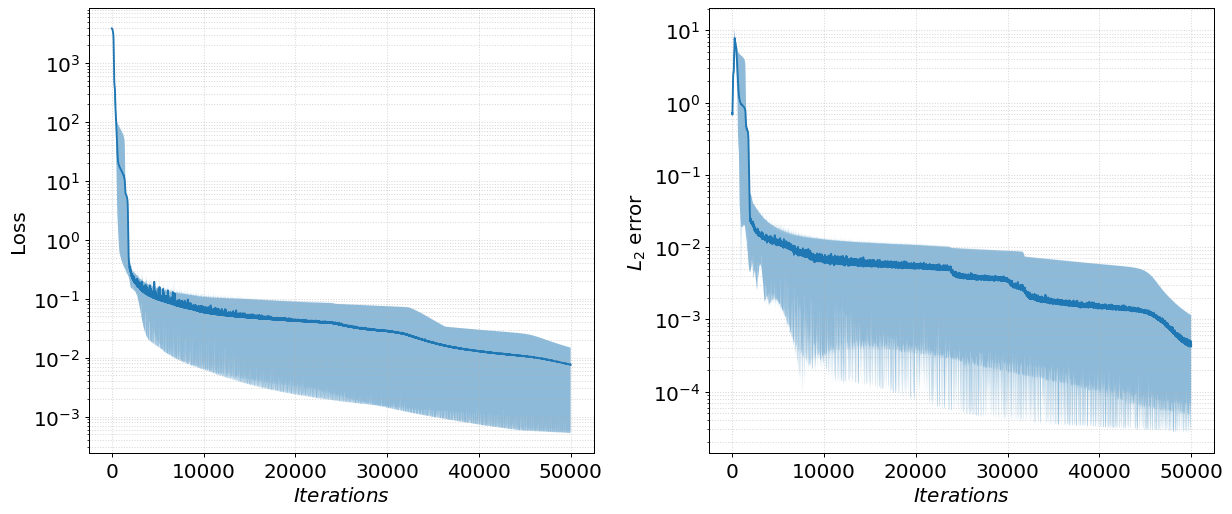

In [173]:
matplotlib.rcParams.update({'font.size': 16})
losses = np.load('/Users/mauriciodiaz.ortiz/Documents/Radboud_Phd/NaturalGradients/NaturalGradientTraining/data/poisson_1D/1D_poisson_baseline_losses.npy')
l2_errors = np.load('/Users/mauriciodiaz.ortiz/Documents/Radboud_Phd/NaturalGradients/NaturalGradientTraining/data/poisson_1D/1D_poisson_baseline_l2_errors.npy')

iterations = 50001
its = np.arange(iterations)

plt.figure(figsize=(14, 6), dpi=90)
plt.subplot(1, 2, 1)
#plt.errorbar(its, losses.mean(axis=1), losses.std(axis=1))
plt.plot(its, losses.mean(axis=1))
plt.fill_between(its, np.quantile(losses, 0.1, axis=1), np.quantile(losses, 0.9, axis=1), alpha=0.5)
plt.xlabel(r'$Iterations$')
plt.ylabel('Loss')
#plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls=":", alpha=0.5)

plt.subplot(1, 2, 2)
#plt.errorbar(its, l2_errors.mean(axis=1), l2_errors.std(axis=1), label='L2')
plt.plot(its, l2_errors.mean(axis=1))
plt.fill_between(its,  np.quantile(l2_errors, 0.1, axis=1), np.quantile(l2_errors, 0.9, axis=1), alpha=0.5)
plt.xlabel(r'$Iterations$')
plt.ylabel(r'$L_2$ error')
plt.yscale('log')
#plt.xscale('log')
plt.grid(True, which="both", ls=":", alpha=0.5)
plt.tight_layout()
plt.show()

In [162]:
l2_errors.std(axis=1)

array([0.03626261, 0.02836575, 0.02134726, ..., 0.00071613, 0.00071072,
       0.00070777])

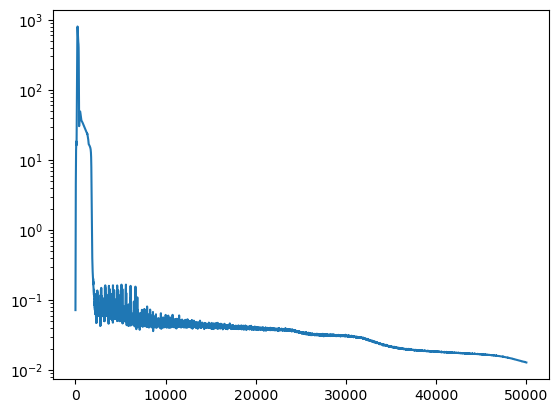

In [155]:
plt.semilogy(losses.std(axis=1))

In [180]:
l2_errors.mean(axis=1)[-1]

0.00044126516433611615